### TMA4320 - Project 2: Physics
### Group 1980

# 0.0 Motivasjon
I fysikk er vi interessert i å simulere fysiske systemer for å forutse hvordan disse vil oppføre seg. For enkle systemer kan vi benytte analytiske metoder i simulasjonene, men for større og mer avanserte er vi ofte nødt til å benytte oss av numeriske tilnærminger. I dette prosjektet skal vi studere en skipsmodell - Vasaskipet, og analysere hvordan dens bevegelse og stabilitet påvirkes av ulike krefter og faktorer. 

For å studere skipet vil vi trenge å løse ordinære differensiallikninger (ODE), og det er flere metoder - både analytiske og numeriske - å gjøre dette på. Vi vil benytte Eulers metode og fjerde ordens Runge-Kutta, som er to svært populære (Kjente? Eulers er vel egentlig ikke populær..?) numeriske metoder. Imens Runge-Kutta (RK4) er en fjerdeordens metode er Eulers metode kun av orden én, hvilket betyr at denne løsningen vil ha en lavere nøyaktighet. Vi vil studere forskjellen på disse to metodene og utforske i hvor stor grad valg av numerisk løsningsmetode påvirker resultatene i simulasjonen.

Til å begynne med vil vi jobbe mer en svært enkel simulasjon preget av mange forenklinger, og så vil vi gradvis utvide denne simulasjonen til å ta hensyn til flere og flere påvikningsfaktorer. Vår simulasjon vil på ingen måte ta hensyn til alle reelle faktorer som spiller en rolle i hvordan ekte båter beveger seg, men vil likevel gi et godt innblikk i mange av de sentrale faktorene som spiller inn.  

# 0.1 Numerisk grunnlag

Ettersom vi ønsker å simulere fysiske systemer numerisk, er det nyttig å benytte noen verktøy som Python tilbyr i sine biblioteker. Numpy er et bibliotek for vitenskapelige beregninger skrevet i C, hvilket betyr at å benytte Nympy ddrastisk reduserer kjøretiden til koden vår. Vi vil også benytte Matplotlib biblioteket for grafisk fremstilling av data. Tempfile-pakken gir oss muligheten til å lagre arrays til filer, hvilket er nyttig for å permanent lagre den beregnede dataen. Mot slutten av projektet vil vi beregne en fouriertransformasjon, og dette benytter vi Scipy-biblioteket til å gjøre. 

In [19]:
# Importing libraries
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile


# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {
    'figure.figsize': (18, 9), 
    'axes.grid': False,
    'lines.linewidth': 2,
    'font.size': 25,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral'
    }

# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

# 0.2 Grunnlag fra mekanisk fysikk

For å beregne skipets bevegelse og hvordan det responderer på de ytre kreftene tar vi utgangspunkt i formler fra den mekaniske fysikken.

Ligingen som beskriver tyngdepunktbevegelsen er
$$
    \sum \vec{F} = m\vec{a} = m \frac{d\vec{v}}{dt} = m \frac{d^2\vec{r}}{dt^2}
$$
hvor vi benytter vektornotasjon ettersom vi har både en x- og en y-komponent.

I tillegg er rotasjonsbevegelsen gitt ved
$$
    \sum \tau = I_{C} \frac{d\omega}{dt}
$$
hvor dreiemomentets vektor alltid vil peke i z-retning i dette prosjektet.

Gjennom å løse disse to uttrykkene for $\frac{d\vec{v}}{dt}$ og $\frac{d\omega}{dt}$ kan vi finne uttrykk for det deriverte av farten og vinkelfarten. Dette vil være nytting når vi senere skal bruke numeriske metoder til å løse differensialligningene.

# 0.3 Fysiske konstanter

Det er hensiktsmessig å definere noen av projektets konstante størrelser som globale variabler. 

In [22]:
# Parameters
g = 9.81 # Gravitational acceleration, [m/s^2]

sigma_0 = 1000 # Mass denisty of water, [kg/m^2]
sigma = 500 # Mass denisty of boat, [kg/m^2]

R = 10 # m, Radius of boat
A_s = 0.5*np.pi*(R**2) # Area of the boats cross-section, [m^2]
A_0 = (sigma*np.pi*(R**2))/(2*sigma_0) # Water displaced by boat at equilibrium, [m^2]
h = (4*R)/(3*np.pi) # Distance from the middle of the boats deck to the center of gravity, [m]

m_boat = A_s*sigma # The mass of the boat, [kg]

# 1.0 Skipsmodell

### 1.1 Skipets fysiske egeskaper
Istedet for å modellere skipet i tre dimensjoner er det hensiktsmessig å istedet se på et todimensjonalt snitt av skipet. Vår skipsmodell tar derfor utgangspunkt i et langt og halvsirkelformet skip med en radius R, som vugger om en akse i skipets lengderetning. Vi definerer skipets masse per flateenhet som $\sigma$ og masse per lengdeenhet som $\lambda$. I tilegg vil massesenteret ligge en lengde $h = 4R/3\pi$ under midtpunktet på dekket. 

Når skipet befinner seg i vann vil det fortrenge en mengde vann, hvor vi definerer mengden fortrengt vann som $A$. I likevekt kan vi beregne mengden fortrengt vann gjennom å beytte Arkimedes lov. 
$$
    m_{fortrengt vann} = A_0\sigma_{0} =  \frac{\sigma\pi R}{2} = m_{skip} \Rightarrow A_{0} = \frac{\sigma\pi R}{2\sigma_{0}}
$$
hvor $\sigma_{0} = 1000 kg/m^2$ er vannets massetetthet.

Dersom skipet begynner å vugge og ikke lengre befinner seg i likevekt vil mengden fortrengt vann ikke lengre være forbli konstant, noe som betyr at oppdriftskraften som virker på båden vil være i en konstant endring. For å beregne hvor mye vann som blir fortrengt kan vi benytte formelen 
$$
    A = \frac{1}{2}R^2(\gamma - sin\gamma)
$$
hvor $\gamma$ er sektorvinkelen og avhenger av rotasjonsvinkelen $\theta$ og den vertikale forflytningen i forhold til likevelt $\Delta y_{C} = y_{C} - y^0_{C}$. 

I følgende funksjon beregner vi fortrengt vann gjennom å bruke sektorvinkelen $\beta$.

In [27]:
water_area = lambda gamma_number: 0.5*(R**2)*(gamma_number - np.sin(gamma_number))

Sektorvinkelen kan beregnes ved å bruke den noe kompliserte formelen

$$
    \gamma = 2arccos(cos(\beta/2)-(4/3\pi)(1-cos\theta) + \Delta y_{C}/R)
$$  
hvor $\beta$ er sektorvinkelen ved likevekt og kan finnes ved å løse likningen 

\begin{equation}
   \beta - sin\beta = \frac{\pi\sigma}{\sigma_{0}} \tag{1}
\end{equation}

For gitt vilkelutslag $\theta$, sektorvinkel $\beta$ og vertikal forflytning $\Delta y_{C}$ kan vi benytte funksjonen under til å beregne gamma.

In [29]:
gamma = lambda beta, theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

Dersom vi antar at skipet har en last med masse $m_{L}$ vil sektorvinkelen endre seg, og være gitt ved likningen

\begin{equation}
   \beta - sin\beta = \frac{2(m_{boat} + m_{L})}{\sigma_{0}R^{2}}
\end{equation}

I følgende funksjon benytter vi Newtons metode til å begregne verdien til $\beta$ for en båt med en vilkårlig last $m_{L}$. Newtons metode krever vi en startverdi som vi valgte valgte til å være $x_{0}=5$, men dette er ikke nødvendigvis den eneste startverdien som er mulig å benytte.

In [25]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
    return x

In [34]:
def print_beta():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print("Beta =",round(np.degrees(beta), 2),"degrees")
print_beta()

Beta = 132.35 degrees


Vi kan se at en båt uten last ($m_{L} = 0$) vil ha en $\beta = 132.35$ grader

En siste størrelse vi trenger når det kommer til beskrivelsen av selve skipet er dets treghetsmoment $I_{C}$ om tyngdepunktet $C$. Denne kan beregnes gjennom å bruke Steines sats
$$
    I_{C} = I_{M} - mh^2 = \frac{1}{2}mR^2(1-\frac{32}{9\pi^2})
$$

Som en forenklig i simulasjonen vår vil vi alltid anta at treghetsmomentet er konstant (uavhenging av om båten har last og hvor denne lasten er plassert). Likevel, dersom man ønsker en er realistisk simulasjon kan man benytte følgende funksjon for å beregne det totale treghetsmomentet for skipet med en last ved en gitt posisjon.

In [23]:
def calculate_I_c(m_load, s_L):
    '''
    This function calculated the ships total rotational inertia of the ship and its load, at the
    relative position of the load affects the total rotational inertia.
    Input:
        m_load: float, the mass of the load [kg]
        s_L:    float, the loads distance from the metacenter [m]
    Output:
        I_c:    float, the ships total rotational inertia [kg/m²]
    '''
    I_boat = 0.5*m_boat*(R**2)*(1-(32/(9*(np.pi**2)))) # Rotational inertia from the ship about C

    r_load = np.sqrt( h**2 + s_L**2 ) # Distance from ship's CM to load's CM
    I_load = m_load*r_load**2   # Rotational inertia from the load about C 
    
    I_c = I_load + I_boat # Use the superposition property of rotational inertias (Steiner's Thm).
    return I_c

### 1.2 Ytre krefter
I våre beregninger skal vi ta hensyn til fire ulike ytre krefter. Gravitasjonskraften virker loddrett nedover og er gitt ved formelen $F_{G} = mg$. Oppdriftskraften er fra Arkimedes lov gitt som $F_{B} = \sigma_{0}Ag$ og virker loddrett oppover.

In [30]:
F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g

Når skipet er i bevegelse, f.eks gynger fra side til side, vil det virke friksjonskrefter mellom skipets skrog og vannet. En tilnærmelse av denne friksjonskraften $f$ er at den er propsjonal med størrelsen av skipets grenseflate mot vannet og vinkelhastigheten $\omega$. Denne grenseflaten vil for oss være gitt som $R\gamma$, hvor $\gamma$ er den samme som definert tidligere. Dette gir at friksjonskraften kan beskrives med formelen
$$
    f = -k_{f}R\gamma\omega
$$
hvor $k_{f}$ er vannets friksjonskoeffesient.



In [31]:
friction = lambda k_f, omega, gamma_number : -k_f * R * gamma_number*omega

Den siste ytre krafta vi velger å inkludere er fra vind og bølger. Vi simulerer denne krafta som en harmonisk oscillerende kraft rettet horisontalt på tvers av lengderetningen, og som har angrepspunkt i samme høyde som vannlinja.
$$
    F_{w}(t) = F_{0}cos\omega_{m}t
$$

Vi fant det hensiktsmessig å ikke definere denne som en global funksjon, men heller beregne denne kraften i delen av simulasjonen hvor vi kommer til å bruke den.


### 1.3 Bevegelig last
Vi skal etter hvert simulere at det befinner seg en bevegelig last på skipets dekk, og studere hvordan denne lasten påviker skipets dynamikk og stabilitet. Lasten simuleres som en punktmasse med masse $m_{L}$, og har en startposisjon hvor den ligger i ro i en posisjon $M$ midt på dekk. Dets posisjon $s_{L}$ spores relativt til midten av dekkes, og er positiv til høyre og negativ til venstre for midtpunket. Dette betyr blant annet at når $s_{L} = R$ befinner lasten seg helt til høyre på dekket og når $s_{L} = -R$ befinner den seg helt til venstre. For enkelhetens skyld ser vi bort fra alle friksjonskrefter og antar at lasten kun påvirkes av gravitasjonskraften og normalkraften. 

På grunn av lastens masse vil den virke med en kraft på skipet. Vi definerer denne kraften som $F_{L}$, og har kompnentene $F^x_{L} = m_{L}g cos\theta sin\theta$ og $F^y_{L} = -m_{L}g cos^2\theta$

I tillegg vil det på grunn av lastens bevegelse også virke et dreiemoment $\tau_{L}$ fra lasten. Denne er gitt som $\tau_{L} = -m_{L}g cos(\theta)s_{L}$.


### 1.4 Hjelpestørrelser og -funksjoner
Her definerer vi en del hjelpefunksjoner som vi får bruk for senere. Vi definerer y=0 til å være i vannflaten. Vi definerer metasenteret $y_M$, skipets massesenter $y_C$, skipets dypeste punkt $y_D$, og angrepspunktet til båten $y_B$. 

In [33]:
#Define the global variables for the equilibrium
y_M_0 = lambda beta: R*np.cos(beta/2)
y_C_0 = lambda beta: y_M_0(beta) - 4*R/(3*np.pi)
y_B_0 = lambda beta: y_M_0(beta) - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = lambda beta: y_M_0(beta) - R

#Values as functions of delta y_C and theta. 
y_M = lambda beta, theta, delta_y_C : y_M_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda beta,delta_y_c : y_C_0(beta) + delta_y_c
y_D = lambda beta, theta, delta_y_c : y_D_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = lambda beta: y_B_0(beta)

# 2 Simulasjon av et forenklet system

Det er ofte nyttig å starte med en enda mer forenklet modell, før man øker kompleksiteten gradvis. I første omgang kommer vi til å neglisjere bevegelsen til skipets massesenter. Vi ignorerer og alle krefter utenom gravitasjonskraften $F_{G}$ og oppdriftskraften $F_{B}$

Selv om i realtieten vil mengden fortrengt vann $A$ variere med vinkelen, kommer vi til i denne delen av simulasjonen avnta at mengden fortrengt vann ikke endrer seg når skipet endrer vinkel. Altså har vi at $A = A_0$, hvilket blant annet medfører at $\vert F_G\vert = \vert F_B\vert \Rightarrow \sum{F} = 0$. 

I tillegg, ettersom tyngdekraften alltid virker gjennom massesenteret, vil ikke denne bidra med noe dreiemoment. Dermed har vi at det kun er dreiemomentet fra oppdriften 

\begin{equation}
    \tau_B = -F_B h sin(\theta)
\end{equation}

som påvirker skipets bevegelse.

Newtons andre lov gir følgende annenordens diffrensiallikning

\begin{equation}
    \sum \tau = I_C \frac{d\omega}{dt} \Rightarrow -F_B h sin(\theta) = I_C \ddot{\theta}
\end{equation}

og for å numerisk løse den annenordens differensiallikningen introduserer vi vektoren $\vec{\omega}(t) = \begin{bmatrix} \theta(t) & \omega(t) \end{bmatrix}^T$. Gjennom å benytte denne deler vi vår annenordens differensiallikning opp i to førsteordens differensiallikninger. Vi kan skrive den deriverte av $\vec{\omega}(t)$ som

$$
    \frac{d\vec{\omega}}{dt} = \begin{bmatrix} \frac{d\theta}{dt} & \frac{d\omega}{dt} \end{bmatrix}^T = \vec{f}(t, \vec{\omega})
$$

### 2.1 Utledning av $\vec{f}(t, \vec{w})$

For å finne et uttrykk for $\vec{f}(t, \vec{\omega})$ benytter vi at $\frac{d\theta}{dt} = \omega$. I tillegg kan vi finne $\frac{d\omega}{dt}$ gjennom formelen for skipets rotasjonsbegegelse, hvor vi som tidligere har argumentert fr hvorfor det kun er dreiemomentet $\tau_{B}$ som påvirker hvordan skipet beveger seg.
$$
    \sum \tau = I_{C}\frac{d\omega}{dt} \Rightarrow \frac{d\omega}{dt} = \frac{ \sum \tau}{I_{C}} = \frac{\tau_{B}}{I_{C}} = -\frac{F_{B}h}{I_{C}}\sin\theta = -\frac{A\sigma_{0}gh}{I_{C}}\sin\theta
$$

Dette gir oss et uttrykket
$$
    \frac{d\vec{\omega}}{dt} = \vec{f}(t, \vec{\omega}) =  \begin{bmatrix} \omega & -\frac{A\sigma_{0}gh}{I_{C}}\sin(\theta) \end{bmatrix}^T 
$$

### 2.2 Eulers metode
Eulers metode er en førsteordens metode for å løse ODE'er med gitte initialverdier, og er den mest grunnleggende metoden vi kan benytte for å løse vår differensiallikning. Ettersom det er en førsteordens metode medfører dette en høy feil sammenliknet med andre metoder. Vi har at det at den lokale feilen er proposjonal med kvadratet av steglengden, og den globale feilen er propsjonal med steglengden.

Vår ODE $\frac{d\vec{\omega}}{dt} = \vec{f}(t, \vec{\omega})$ kan ved bruk av Eulers metode løses ved å bruke formelen
$$
    \vec{\omega}_{i+1} = \vec{\omega}_{i} + h\vec{f}(t_{i}, \vec{\omega}_{i})
$$

hvor h er steglengden (avstanden mellom t-verdiene). Dersom vi kjenner en initialverdi $\vec{\omega}(t = t_{0})$ kan vi dermed tilnærme hva $\vec{\omega}(t)$ vil være ved andre tidspunkt.

Vi definerer først en funksjon euler_step som returnerer den neste verdien av t og w, gitt en funksjon f, steglenge h, og tidligere verdier av t og f.

In [35]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    
    w_new = w + h_step*f(t, w)
    return t+h, w_new

Ettersom Eulers metode har flere kjente svakheter, lager så en generell ODE løser som tar inn parameteren method, slik at vi kan velge mere robuste step-funksjoner på et senere tidspunkt. Vi legger også inn muligheter adaptiv steglengde.

In [8]:
def solve_ODE(f, t_0, t_end, w_0, h_0, method, fixed_step = True, tol = 1e-6, max_iter = 1e5):
    '''
    Funksjon som løser differensial ligninger på en brukerdefinert måte.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_0: Dersom vi ønsker dynamisk steglengde vil dette være startsteglengden
            ellers blir dette den konstante steglengden
        tol: The tollerance if we wish to use adaptive step size
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    t_num = np.array([t_0])
    w_num = w_0
    # Set the running values
    t_n = t_0
    w_i = w_0
    h_step = h_0

    if fixed_step:
        N = int( (t_end-t_0)/h_step + 1)
        t_num, h_step = np.linspace(t_0, t_end, N, retstep=True)  # Use linpace, as numpys documentation suggests this for
                                            # non-integer values, we also get the closed interval [t_0, t_end].
        # print(f't_num:\n {t_num}\n t_num minus one:\n {t_num[0:-1]}')        

        # This loop will iterate over all the t-values exept the last one. The reason for this is because the w corresponding
        # to the last t-value is calculated at the second last t-value, and so, both arrays have an equal lenght.
        for t_n in t_num[0:-1]: 
            w_i = method(f, t_n, w_i, h_step)[1] # Here we are only interrested in w, as the step size is fixed
            #print(f'w_num:\n {w_num}\n\n w_{i+1}:\n {w_n}\n\n\n\n ')
            w_num = np.concatenate(( w_num, w_i), axis=1)
    else: 
        current_iter = 0
        while t_n < t_end-1e-10: # take truncation error into account        
            if t_n + h_step > t_end:
                h_step = t_end-t_n
                
            # One step with the method:
            t_try, w_try, err_est, p = method(f, t_n, w_n, h_step)
            current_f_calls += 1
            
            if err_est <= tol:
                # Use the solution
                t_n = t_try
                w_n = w_try
                
                # Store the solutions
                t_num = np.append(t_num, t_n)           
                w_num = np.concatenate((w_num, np.array([w_n])))
                
            
            # Adjust the step size, start by defining facors
            P = 0.8 # Pessismist facor, normally between 0.5 and 0.95
            
            h_step = P*( (tol/err_est)**(1/(p+1)) )*h_step

            if current_iter >= max_iter:
                print('Maximum number of function calls are reached.')
                return t_num, w_num
    return t_num, w_num

### 2.3 Løser differensiallikningen med Eulers metode

In [ ]:
def test_euler():
    # f = lambda t, w: np.array([
    #     w[1],
    #     -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
    #     ])
    
    # This function is equivalent
    def f(t, w):
        dw = np.array([
            w[1],
            -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
        return dw

    # Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step1 = 0.001  #The step size of our simulation
    h_step2 = 0.01
    h_step3 = 0.1


    # Calculate the angles and angle velocities in the given time intervall using the Euler method
    t_num1, w_num1 = solve_ODE(f, t_0, t_end, w_0, h_step1, euler_step)
    t_num2, w_num2 = solve_ODE(f, t_0, t_end, w_0, h_step2, euler_step)
    t_num3, w_num3 = solve_ODE(f, t_0, t_end, w_0, h_step3, euler_step)


    theta_num1, omega_num = w_num1[0:2]
    theta_num2, omega_num = w_num2[0:2]
    theta_num3, omega_num = w_num3[0:2]

    # Plot the angles vs time
    plt.plot(t_num1, np.rad2deg(theta_num1), label = "dt = 0.001")
    plt.plot(t_num2, np.rad2deg(theta_num2), label = "dt = 0.01")
    plt.plot(t_num3, np.rad2deg(theta_num3), label = "dt = 0.1")
    plt.axhline(20, color = "black", linestyle = "--", label = r"Referanseverdi, $\theta$ = 20")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [$^\circ$]')   
    # plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

test_euler()

Her illustreres et av problemene med Eulers metode: amplituden øker for hver periode, og dette gir ikke fysisk mening når systemet vårt kun har med tyngekraft og oppdrift. Dette fenomenet vil oppstå uansett hvor lav steglende man bruker, det vil bare ta lenger tid

En steglengde på h=0.001 gir gode resultater for vårt tidsintervall, samtidig som kjøretiden er veldig rask. Vi ser på plottet under at dette ligner på en harmonisk oscillator, som virker fornuftig gitt våre forenklinger av systemet. Ettersom det kun er tyngdekraft og oppdrift som har en effekt, kan man tenke at momentet fra oppdriften alltid vil virke i motsatt retning av utslagsvinkelen $\theta$, og ettersom alle friksjonskrefter er idealisert bort, vil den aldri stoppe opp, så da blir det åpenbart en harmonisk oscillator.

### 2.4 Småvinkelapproksimasjon

Dersom vi bruker liten nok steglengde, kombinert med en begrenset tidshorisont, har vi en ODE-løser som er brukbar. Vi tar derfor en liten avstikker for å analysere en av fysikkens mest brukte approksimasjoner, nemlig $sin(\theta) \approx \theta$. 

Hvis vi ser på diffligningen i oppgaven over, med denne approksimasjonen, får vi
\begin{equation}
    -mgh \theta = I_C \ddot{\theta}
\end{equation}
der $F_B =A\sigma_0 g = mg$ da vi har antatt konstant $A$.

Denne difflikningen kan løses numerisk med samme metode som over, og vi kan sammenligne verdiene.


(Her må vi plotte både ved 1 og 20 grader, så her burde vi kanskje bruke den nye plottefunksjonen..?)

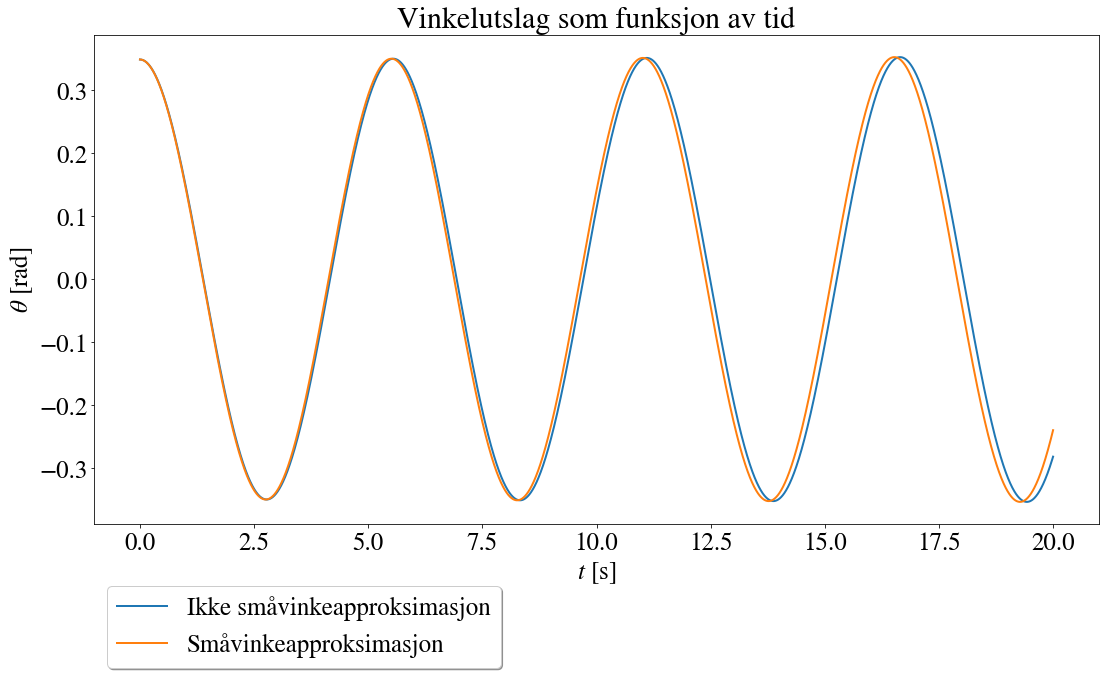

In [36]:
def angle_approx_comparison():
    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])

    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * np.sin(w[0])
    ])
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * w[0]
    ])

    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation
    #######################################################################################
    #       Solve diff. eqn. by the given methods, and 
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)

    
    theta_num, omega_num = w_num[0:2] #Hvordan funker det her egt? 
    # print(theta_num)
    # theta_num = w_num[0]
    # print(theta_num)
    theta_num_small_angle_approx, omega_num_small_angle_approx = w_num_small_angle_approx[0:2]
    # theta_num_small_angle_approx[0]


    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    # plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)        
    plt.legend( 
        bbox_to_anchor=(0,-0.1),
        loc='upper left',
        shadow = True
        )
    plt.show()

angle_approx_comparison()

Vi ser at for $\theta = 1\deg$ er plottene praktisk talt identiske. For $\theta = 20\deg$ er det en synlig forskjell, men fortsatt en dugelig approksimasjon i tilfeller der ekstrem nøyaktighet ikke er vesentlig. Så totalt sett er det en veldig nyttig approksimasjon.

### 2.5 Fjerde ordens Runge-Kuttas metode

Vi velger nå å implementere en litt mer robust ODE-løser, nemlig den klassiske Runge-Kutta metoden. Denne vil nemlig ikke ha samme problemet som Eulers metode når det kommer til håndtering av amplitudene.

In [37]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''

    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h
    
    return t_new, w_new

Vi tester Runge-Kutta metoden gjennom å benytte den til å løse differensiallikningen vår.

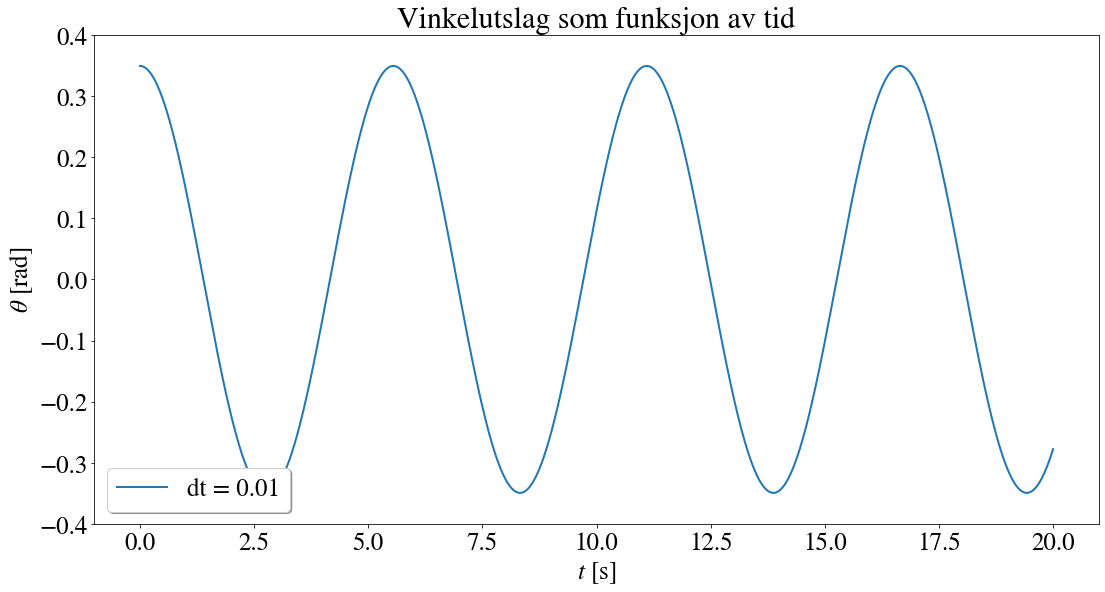

In [38]:
def test_runge_kutta():

    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])
    
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])


    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.01  #The step size of our simulation
    #######################################################################################

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    theta_num_rk4, omega_num_rk = w_num_rk4[0:2]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    
test_runge_kutta()

Som man kan se likner plottet svært mye på det vi fikk da vi brukte Euler-metoden, men i realiteten vil disse dataene være mye mer nøyaktige. La oss utforske hvor mye bedre Runge-Kutta-metoden er i forhold til Euler-metoden gjennom å sammenlikne dem med den analytiske løsningen.

### 2.6 Analytisk løsning av differensiallikningen
Dersom vi benytter småvinkelapproksimasjonen kan vi løse differensiallikningen vår analytisk. Vi begynner med å definere variabelen

$$
    \omega_{0} = \sqrt{\frac{mgh}{I_{C}}}
$$

og skriver så om differensiallikningen til å være på formen
$$
    I_{C}\frac{d^{2}\theta}{dt^{2}} = -mgh \theta \Rightarrow \frac{d^{2}\theta}{dt^{2}} = \frac{mgh}{I_{C}}\theta = \omega_{0}^{2}\theta
$$

Dette minner mistenkelig mye på differensiallikningen til en harmonisk oscillator. Gjetter dermed på en løsning på formen

$$
    \tilde{\theta}(t) = A\sin(\omega_{0}t) + B\cos(\omega_{0}t)
$$

Prøver å sette $\tilde{\theta}$ inn i differensiallikningen vår for å sjekke om gjetningen er korrekt
$$
    \frac{d^{2}\tilde{\theta}}{dt^{2}} = -\omega_{0}^{2}A\sin(\omega_{0}t) - \omega_{0}^{2}B\cos(\omega_{0}t) = -\omega_{0}^{2}\tilde{\theta}
$$

Som vi kan se løser $\tilde{\theta}(t) = A\sin(\omega_{0}t) + B\cos(\omega_{0}t)$ differensiallikningen, og er dermed en analytisk løsning.

### 2.7 Differanse mellom analytisk og numeriske løsninger

Vi antar at vi har startverdiene $\theta(t = 0) = 0.01$ radianer og $\omega(t = 0) = 0$ radianer/s. Benytter dette til å finne konstantene $A$ og $B$

$$
    \tilde{\theta}(t = 0) = A\sin(0) + B\cos(0) = 0 + B = 0.01 \Rightarrow B = 0.01 \\
    \frac{d\tilde{\theta}}{dt}(t = 0) = \omega(t = 0) = \omega_{0}A\cos(0) - \omega_{0}B\sin(0) = \omega_{0}A = 0 \Rightarrow A = 0
$$

Med disse startverdiene har vi dermed den analytiske løsningen
$$
    \tilde{\theta}(t) = 0.01\cos(\omega_{0}t) = 0.01\cos(\sqrt{\frac{mgh}{I_{C}}}t)
$$


Det er mulig å bruke den analytiske løsningen som sammenligningsgrunnlag for å vurdere feilen til henholdsvis Euler og Runge Kutta-metodene for diverse steglengder. Vi velger her å bruke logaritmisk akse på både x og y aksen når vi plotter, da vi beveger oss over flere størrelsesordener. Til dette bruker vi en logaritmisk linspace som utgangspunkt for å velge h-verdier.

In [ ]:
def anal_vs_num():
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    def f_analytic(t, theta_0):
        return theta_0*np.cos( np.sqrt( (m_boat*g*h)/calculate_I_c(0, 0) )*t )
    
    # To be used in numerical solutions
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * w[0]
        ])
    f_not_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
    
    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])
    # def f_not_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*  np.sin(w[0]),0,0,0,0,0,0])


    # theta_0 = np.radians(0.01)
    # omega_0 = 0
    # w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    # t_0 = 0
    # t_end = 20


    #######################################################################################
    #       Define the inital condititons, time intervall, the array of step sizes, 
    #       and the analytic value at t=20s
    theta_0 = np.array([0.01])
    omega_0 = np.array([0])
    w_0 = np.array([
        theta_0, 
        omega_0
    ]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_steps = 10**np.linspace(-1, -4, 30) #logaritmic linspace


    #######################################################################################
    #       Find the values of different methods (including analytic) at t=20s
    #       using different step sizes
    f_analytic_t_20 = f_analytic(t_end, theta_0) # Analytic value at t=20s

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])

    # Iterate through all the desired step sizes, and store them
    for h_step in h_steps:
        theta_euler    =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step)[1][0] #[1]: w, [0]: theta
        theta_rk4      =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, rk4_step)[1][0]
        
        # t_euler, theta_euler = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step) #[1]: w, [0]: theta)
        # t_rk4, theta_rk4 = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step) #[1]: w, [0]: theta)
        # print(f'last euler t: {t_euler[-1]}')
        # print(f'last rk4 t: {t_rk4[-1]}')

        # Store the angle at t=20s (the last angle)
        theta_t20_arr_euler =   np.append(theta_t20_arr_euler, theta_euler[-1])
        theta_t20_arr_rk4   =   np.append(theta_t20_arr_rk4 , theta_rk4[-1])


    difference_euler    = theta_t20_arr_euler   -   f_analytic_t_20
    difference_rk4      = theta_t20_arr_rk4     -   f_analytic_t_20
    # difference_rk4 = np.abs(difference_rk4)
    
    #######################################################################################
    #       Save the data to a file
    np.savez(
        'simulation_data/difference_at_t20',
        h_steps = h_steps,
        difference_euler = difference_euler,
        difference_rk4 = difference_rk4
        
        )
#anal_vs_num()


Ettersom denne funksjonen hadde en kjøretid på ca 2 minutter, valgte vi å lagre dataene for senere bruk.

In [ ]:
#######################################################################################
#       Plot the differences
def plot_difference():
    
    diff_data = np.load('simulation_data/difference_at_t20.npz')
    h_steps, difference_euler, difference_rk4 = diff_data['h_steps'], diff_data['difference_euler'], diff_data['difference_rk4']

    plt.yscale("log")
    plt.xscale("log")
    print(h_steps)
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, np.abs(difference_euler), label = "Euler")
    plt.plot(h_steps, np.abs(difference_rk4), label = "RK4")
    plt.plot(h_steps, np.abs(difference_rk4),'o', label = "Logaritmisk linspace")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=1, shadow = True)
    # plt.axvline(10e-3)
    # plt.axvline(10e-4)
    # plt.axhline(10**-(14.5))
    # plt.axhline(10**-10.5)

    # plt.axhline(10**-(3))
    # plt.axhline(10**-4.1)
    # plt.show()
    # print("euler: ",(10**-3 - 10**-4.1)/10 )
    # print("rk4: ", (10**-10.5 - 10**-14.5)/10)


    # plt.yscale("log")
    # plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    # plt.plot(h_steps, difference_euler, label = "Euler")
    # plt.plot(h_steps, difference_rk4, label = "RK4")

    # plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    # plt.xlabel('$h$')           
    # plt.ylabel(r'$\Delta\theta$ [rad]')

    # plt.legend(loc=2, shadow = True)
    # plt.show()

plot_difference()


Vi ser at Runge-Kutta metoden er vesentlig bedere for alle steglengder. 

Begge funksjonene får åpenbart en lavere feil når vi reduserer steglengden, men vi ser at når vi nærmer oss $10^-16$ så er det ikke lenger noe forbedring å hente fra reduksjon av steglengde. Dette er ikke spesifikt til RK4, det er rett og slett fordi vi har nått maskinpresisjonen for floats på et 32 bit system. Dette kan man enkelt se ved hjelp av kodelinjen under, der man trekker fra hverandre tall slik at vi forventer at svaret blir null, eller ved hjelp av numpy-funksjonen epsilon.

Hvis vi ser på området som ikke er påvirket av maskinpresisjon, ser vi at Runge-Kutta metoden for en gitt endring i steglengde vil få en større reduksjon. Denne økningen er på plottet vårt ca 2.5 ganger så stort. (FORVENTET VI DETTE..? Jeg så for meg en større økning.. første orden vs fjerde orden)

Alt i alt ser vi at RK4 er en god ODE-løser, som gir liten feil, og er stabil.

In [39]:
print("Machine error: 0 = 7./3 - 4./3 - 1 = ",7./3 - 4./3 -1)

Machine error: 0 = 7./3 - 4./3 - 1 =  2.220446049250313e-16


# 3 Simulasjon av en mer avansert skipsmodell

Vi skal nå implementere flere krefter og krav til simulasjonen vår. Dette gjør de mer virkelighetsnær, men gir oss også differensiallikninger som er mye vanskeligere - om ikke umulige - å løse analytisk. Dermed vil de nueriske metodene som ble introdusert tidligere komme til god nytte.

### 3.1 Utlede en generell funksjon $\vec{f}$

For å ende opp med et simulasjon som kan ta høyde for ulike tilfeller av hvor forskjellige krefter som virker på båden, ønsker vi å utlede en funksjon $\vec{f}(t, \vec{\omega}) = \frac{d\vec{w}}{dt}$ som er så generell som mulig. Dette vil kreve at vi tar hensyn til gravitasjon, oppdrift, bevegelig last, friksjon og vind/bølger.

Vi tar utgangspunkt i vektoren
$$
    \vec{w} =  \begin{bmatrix} \theta & \omega & x & y & v_{x} & v_{y} & s_{L} & v_{L} \end{bmatrix}^T 
$$

hvor $\theta$ og $\omega$ er vinkelutslaget og -hastigheten, $x$ og $y$ er posisjonen til massesenteret, $v_{x}$ og $v_{y}$ er farten til massesenteret i hhv. x- og y-retning, $s_{L}$ er posisjonen til lasten ift. midten av dekket, og $v_{L}$ er hastigheten som lasten beveger seg bortover dekket. 

Funksjonen vi ønsker å finne må da løse likningen
$$
    \frac{d\vec{w}}{dt} = \begin{bmatrix} \frac{d\theta}{dt} & \frac{d\omega}{dt} & \frac{dx}{dt} & \frac{dy}{dt} & \frac{dv_{x}}{dt} & \frac{dv_{y}}{dt} & \frac{ds_{L}}{dt} & \frac{dv_{L}}{dt} \end{bmatrix}^T = \vec{f}
$$

For å løse likningen vil vi ta utgangspunkt i Newtons 2. lov for bevegelse $\sum{\vec{F}} = m\frac{d\vec{v}}{dt}$ og for dreiemonoment $\sum{\vec{\tau}} = I_{C}\frac{d\vec{\omega}}{dt}$. Ettersom vi fra nå av skal vi ta hensyn til at mengden vann som båten fortregner vil variere, hvilket betyr at massesenteret vil begynne å bevege på seg, vi resulterer også i at disse likningene vil være koblede. 

Totalt er seks krefter som virker på båten. I x-retning har vi
\begin{align} 
    f &= -k_{f}R\gamma\omega \\
    F_{w}(t) &= F_{0}cos\omega_{m}t \\
    F^x_{L} &= m_{L}g cos\theta sin\theta
\end{align} 

og i y-retning har vi

\begin{align} 
    F_{G} &= -m_{total}g \\
    F_{A} &= A\sigma_{0}g \\
    F^y_{L} &= -m_{L}g cos^2\theta
\end{align} 

Noen av kreftene bidrar også med et dreiemoment på båten, og vi har fire av disse
\begin{align} 
    \tau_{B} &= -F_{B}h\sin(\theta) \\
    \tau_{f} &= f(y_{C} - (R(\cos(\gamma/2)-1))) \\
    \tau_{w} &= F_{w}y_{C} \\
    \tau_{L} &= -m_{L}g\cos(\theta)s_{L}
\end{align} 

Vi beynner med rotasjonen. Den deriverte av $\theta$ ($\frac{d\theta}{dt}$) er lik $\omega$, og for å finne den deriverte av $\omega$ bruker vi
$$
    \sum{\tau} = I_{C}\frac{d\vec{\omega}}{dt} \Rightarrow \frac{d\vec{\omega}}{dt} = \frac{\sum{\tau}}{I_{C}} = \frac{\tau_{B} + \tau_{f} + \tau_{w} + \tau_{L}}{I_{C}}
$$

For posisjonene har vi at $\frac{dx}{dt} = v_{x}$ og $\frac{dy}{dt} = v_{y}$, og vi finner de deriverte av fartskompnentene ved å bruke Newtons 2. lov
$$
    \sum{F_{x}} = m_{tot}\frac{dv_{x}}{dt} = f + F_{w} + F^x_{L} \Rightarrow \frac{dv_{x}}{dt} = \frac{f + F_{w} + F^x_{L}}{m_{tot}}
$$
$$
    \sum{F_{y}} = m_{tot}\frac{dv_{y}}{dt} = F_{G} + F_{A} + F^y_{L} \Rightarrow \frac{dv_{y}}{dt} = \frac{F_{G} + F_{A} + F^y_{L}}{m_{tot}}
$$

Til slutt kan vi bestemme bevegelsen til lasten gjennom at $\frac{ds_{L}}{dt} = v_{L}$ og at bevegelsen til lasten langs dekket kun påvikes av gravitasjonskraften (summen av kreftene normalt på dekket blir null)
$$
    \sum{F} = m_{L}\frac{dv_{L}}{dt} = m_{L}g\sin(\theta) \Rightarrow \frac{dv_{L}}{dt} = g\sin(\theta)
$$

Dersom vi kombinerer alle disse utregningenen vil vi få funksjonen
$$
    \vec{f} = \begin{bmatrix} \omega & \frac{\tau_{B} + \tau_{f} + \tau_{w} + \tau_{L}}{I_{C}} & v_{x} & v_{y} & \frac{f + F_{w} + F^x_{L}}{m_{tot}} & \frac{F_{G} + F_{A} + F^y_{L}}{m_{tot}} & v_{L} & g\sin(\theta) \end{bmatrix}^T
$$

Selv om denne funksjonen kan virke svært komplisert er det ikke ofte vi vil bruke all dens funksjonalitet på én gang. Dersom det f.eks ikke skal simuleres at skipet har en bevegelig last kan vi sette $m_{L} = 0$, hvilket forenkler flere av uttrykkene. I likhet kan vi gjøre det samme med vind/bølger ved å sette $F_{0} = 0$ og friksjon ved å sette $k_{f} = 0$.

### 3.2 Båt-klasse

Vi fant det hensiktsmessig å lage en klasse Boat_state ettersom det gjorde at vi i mindre grad måtte forholde oss til hva som var lokale og globale variabler. For eksempel, dersom lasten faller av dekk skal denne settes til null, og da viste det seg å være lett om vi har en egen båt-klasse som inkluderer massen til lasten. Tilsvarende lagrer vi massen til båten, og inkluderer funksjoner som beregner $\beta$ og totalmassen. 

In [10]:
# Class containing values and function related to the boat
class Boat_state:
    def __init__(self, m_L, m_boat, fences_bool, capsized_bool):
        self.m_L = m_L
        self.m_boat = m_boat
        self.fences = fences_bool
        self.capsized = capsized_bool
    def m_tot(self):
        return self.m_L + self.m_boat
    def beta(self):
        # return calculate_beta((np.pi*sigma*(R**2)+2*self.m_L)/(sigma_0*(R**2)), 5)
        return calculate_beta((2*(self.m_boat+self.m_L))/(sigma_0*(R**2)), 5)

### 3.3 Universell funksjon for senere simulasjoner

Noen reelle globale variabler definerer vi her:

In [ ]:
omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

For å unnge mye kopiering av kode senere definerer vi en universell funksjon som kan ta høyde for alle de ulike tilfellene av frefter som vi ønsker å simulere, dette gir oss en svært fleksibel kode.

In [40]:
def universal_func(w_start_vals, t_end_input, h_step_input, F_0, k_f, omega_w_input, m_boat_input, m_L_input, fences_bool_input = False):
    '''
    Universell funksjon som kan benyttes til å beregne bevegelsen til skipet for mange ulike tilfelle.
    Gjennom hva man skriver i funksjonens argument kan man bla. simulere påvikningen friksjon, bølger og last.
    Inn:
        w_start_vals: s-array, inneholder alle startverdier 
            w_start_vals = [theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0, s_L_0, v_L_0]
        t_end_input: float, sluttid til simulasjonen
        h_step_input: float, steglengde til simulasjonen
        F_0: float, amplitiden til den harmoniske funksjonen som beskriver vind/bølger
        k_f: float, friksjonskoeffesient
        omega_w_input: float, vinkelfrekvensen til den harmoniske funksjonen som beskriver vind/bølger
        m_boat_input: float, massen til båten
        m_L_input: float, massen til lasten
        fences_bool: bool, if the boat will have fences or not, determines wether the load will fall of the ship
    Ut:
        t_num: array, tidsverdier
        w_num: array, w som inneholder alle beregnede verdier
    '''
    # Creating a boat-class
    boat = Boat_state(
        m_L_input, 
        m_boat, 
        fences_bool_input, 
        capsized_bool = False
        )
    
    
    # Equating the moment of intertia
    I_C = calculate_I_c(0, 0)
    
    def f(t, w):   
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''   
        # Checks if the boat already has capsized
        if boat.capsized == True:
            w[0] = np.pi/2 * np.sign(w[0])
            w[1] = 0
            w[2] = 0
            w[3] = 0
            w[4] = 0
            w[5] = 0
            w[6] = 0
            w[7] = 0
        
        
        if np.abs(w[6]) > R and boat.m_L != 0 and boat.fences == False:
            boat.m_L = 0
            
        elif np.abs(w[6]) > R and boat.m_L != 0 and boat.fences == True:             
            if w[6] > 0:
                w[6] = R
            else:
                w[6] = -R
            w[7] = 0
        
        
        # Retrieving values from the boat-class
        m_boat_step = boat.m_boat
        m_L_step = boat.m_L
        beta_step = boat.beta()
        m_tot_step = boat.m_tot()
        

        # Vertical displacement
        delta_y_C_step = w[3] - y_C_0(beta_step) 
        
        # Sector-angle
        gamma_step = 2*np.arccos(np.cos(beta_step/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_C_step/R)
        
        # Checks if the boat capsizes
        if boat.capsized == False and w[0] > (0.5*(np.pi - gamma_step)):
            boat.capsized = True
            w[0] = np.pi/2 * np.sign(w[0])
            w[1] = 0
            w[2] = 0
            w[3] = 0
            w[4] = 0
            w[5] = 0
            w[6] = 0
            w[7] = 0
       
        # Repressed water
        A_step = water_area(gamma_step)
        
        # Gravitation and bouancy
        # F_G_step = F_G(m_boat)
        F_G_step = F_G(m_boat_step)
        F_B_step = F_B(A_step)
        
        # Friction and wind/waves
        F_w_step = F_0*np.cos(t*omega_w)
        F_f_step = friction(k_f, w[1], gamma_step)
        
        # The components of the contact-force between the load and the ship
        #F_L_x_step = m_L*g*np.cos(w[0])*np.sin(w[0])
        F_L_x_step = m_L_step*g*np.cos(w[0])*np.sin(w[0])
        #F_L_y_step = -m_L*g*(np.cos(w[0])**2)
        F_L_y_step = -m_L_step*g*(np.cos(w[0])**2)
 
        # Torque 
        tau_B_step = -F_B_step*h*np.sin(w[0])
        tau_f_step = F_f_step*(w[3] - (R*(np.cos(gamma_step/2)-1)))
        tau_w_step = F_w_step*w[3]
        #tau_L_step = -m_L*g*np.cos(w[0])*w[6]
        tau_L_step = -m_L_step*g*np.cos(w[0])*w[6]
    
        # Equate values for the derivative of the w-vector, and combining them in an array
        d_theta = w[1]
        d_omega = (1/I_C)*(tau_B_step + tau_f_step + tau_w_step + tau_L_step)
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = (1/m_tot_step)*(F_f_step + F_w_step + F_L_x_step)
        d_v_y   = (1/m_tot_step)*(F_G_step + F_B_step + F_L_y_step)
            
        d_s_L = w[7]
        d_v_L = -g*np.sin(w[0])
        
        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y, 
            d_s_L,
            d_v_L
        ])
        
        return dw

    # Initial values
    theta_0 = np.array([np.radians(w_start_vals[0])])
    omega_0 = np.array([w_start_vals[1]])
    x_C_0 = np.array([w_start_vals[2]])
    
    # Tenk ut en god løsning på dette. 
    beta_step = boat.beta() ###OBS OBS: ER DETTE RIKTIG? Mvh Matias :)
    initial_y_C = np.array([y_C_0(beta_step)])
    #initial_y_C = np.array([w_start_vals[3]])
    
    v_x_0 = np.array([w_start_vals[4]])
    v_y_0 = np.array([w_start_vals[5]])
    s_L_0 = np.array([w_start_vals[6]])
    v_L_0 = np.array([w_start_vals[7]])

    # Combining the initial values into an array
    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0, 
        s_L_0, 
        v_L_0
    ])

    # Running the solve_ODE-function
    t_0 = 0
    t_num, w_num = solve_ODE(f, t_0, t_end_input, w_0, h_step_input, rk4_step)
    # w_num = check_capsizing(w_num)
    return t_num, w_num

For vårt formål er det også hensiktsmessig å lage en plottefunksjon som kan benyttes til å grafisk fremsille vår beregnede data. Funksjonen tar inn dataen i arrays, hvilket gjør det mulig å plotte flere funksjoner i samme figur.

In [12]:
def plot_func(t_num_arr, values_2d_arr, label_arr, title_name, x_axis_name, y_axis_name, horizontal_lines=[], vertical_lines=[] ):
    '''
    Plottefunksjon for grafisk fremstilling av vår data.
    Inn:
        t_num_arr: 2D-array, t-verdier som vil plottes langs x-aksen
        values_2d_arr: 2D-array, vilkårig data som vil plottes langs y-aksen
        label_arr: array, array som inneholder labelsene til de ulike funksjonene
        title_name: string, figurens tittel
        x_axis_name: string, navnet til x-aksen
        y_axis_name: string, navnet til y-aksen
        horizontal_lines: list, 
        vertical_lines: list, 
    '''
    for i in range(len(values_2d_arr)):
        plt.plot(t_num_arr, values_2d_arr[i], label = label_arr[i])
    for i in horizontal_lines:
        plt.axhline(i,color="black",linestyle="--")

    for i in vertical_lines:
        plt.axvline(i,color="black",linestyle="--")

    plt.title(title_name)
    plt.xlabel(x_axis_name)           
    plt.ylabel(y_axis_name)   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=2, shadow = True)
    plt.show()

### 3.4 Simulasjon med varierende mengde fortrengt vann
I første omgang velger vi å se på hva som skjer dersom vi ikke lenger antar at arealet til det fortrenge vannet er konstant.

In [ ]:
def oppg_2b_solve():
    w_start_vals = [20, 0, 0, 0, 0, 0, 0, 0]

    F_0 = 0
    k_f = 0
    t_end = 20
    h_step = 0.01

    m_boat = A_s*sigma
    m_L = 0*m_boat

    omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
    omega_w = 0.93*omega_0

    # m_boat = A_s*sigma
    # m_L = 0*m_boat
    
    t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)
    #print(np.min(w_num[3]) + (np.max(w_num[3])-np.min(w_num[3]))/2)
    np.savez(
        'simulation_data/2b',
        t_num = t_num,
        w_num = w_num
        
        )

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    y_num = w_num[3]
    plot_func(t_num, [y_num], [f"$h = 0.01$"], "Massesenters høyde som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]',[y_C_0(beta), np.min(w_num[3]) + (np.max(w_num[3])-np.min(w_num[3]))/2])
    plot_func(t_num, [w_num[0]], [f"$h = 0.01$"], "Vinkelutslaget som funksjon av tid", '$t$ [s]', r'Vinkelutslag, $\theta$ [m]')

oppg_2b_solve()


#print(-0.2 + (0.07803958045574202))

Den nedre stiplede svarte linjen er massesenterets avstand fra vannlinja, som representerer vår tidligere tilnærmelse der vi antok at arealet av det fortrengte vannet endrer seg. Som vi ser så starter båten på samme sted, men den vil raskt flytte seg høyere opp, der den svinger rundt en likevektsverdi på omtrent $-0.078$. Dette fremkommer av at oppdriften til vannet blir større, ettersom arealet til det fortrengte vannet øker, som fører til større oppdriftskrefter når roterer. (Stemmer dette faktisk? Dobbeltsjekk) 

Det er altså en merkbar effekt på y-verdien, da den har gått fra å være i ro, til å oscilere rundt en verdi som er omtrent 12cm høyere opp i vannet.

### 3.5 Kantring
Etter hvert som vi tester flere og flere krefter må vi ta stilling til at hvis utslagsvinkelen $\theta$ blir stor nok til at deler av dekket er i kontakt med vannet, vil vannet som flommer inn i båten føre til at båten kantrer. Dette har vi løst ved å sette alle komponenter av $w$ lik 0 fra og med det tidspunktet båten kantrer, $t = t_i$. Eneste unntaket et $\theta$-verdiene, de settes til 
\begin{equation} 
\theta_{j} = \frac{\pi}{2} sgn(\theta_{i-1}) \quad    \forall \quad j > i
\end{equation}
 Vi bruker $sgn(\theta)$ fordi den sørger for at båten tipper riktig vei. For positive $\theta$-verdier, altså når båtens kjøl peker til høyre

\footnote{Da vi ikke har definert om vi ser på båten forifra eller bakifra, kan vi ikke definere styrbord og babord.}

 
, vil $sgn(\theta)=1$, som sørger for at vinkelen blir $ 90^{\circ} $, altså at høyre del av båten peker opp i lufta. Hvis båten kantrer på venstre side blir $sgn(\theta)$ negativ, så venstre del av båten peker opp.

Måten vi sjekker om båten har kantret er kriteriet 
\begin{equation}
    \theta > \frac{\pi - \gamma}{2}
\end{equation}

For å finne den laveste $\omega$ -verdien som kantrer, prøvde vi oss først frem og legger merke til at det er imellom 0.42 og 0.44 et sted. Deretter brukte vi rå kraft, og looper igjennom en linspace fra 0.42 og 0.44, og sjekker om båten kantret. Etter litt testing konkluderer vi at $\omega = 0.43142$ førte til at båten kantret etter ca $620$ sekunder. Det er verdt å nevne at dette resultatet fysisk sett er litt rart, da det betyr at båten på en eller annen måte tilføres energi. Den svinger frem og tilbake (veldig) mange ganger, før den plutselig hadde høy nok hastighet til at den kantret. 

In [41]:
#omega_lowest = 0.4335
#omega_lowest = 0.432

def oppg_2c():

    w_start_vals = [0, 0.4315, 0, 0, 0, 0, 0, 0]

    F_0 = 0
    k_f = 0

    t_end = 100
    h_step = 0.01
    m_boat = A_s*sigma
    m_L = 0*m_boat
    omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
    omega_w = 0.93*omega_0
    
    #denne koden funker men er litt shit, skal vi beholde den, nå som vi fant den laveste verdien?
    def find_omega_lowest():
        def capsize_check(theta_arr):
            return np.pi/2 in np.abs(theta_arr)
        omega_candidates,step = np.linspace(0.43,0.433,1000,retstep=True)
        for omega in omega_candidates:
            w_start_vals = [0, omega, 0, 0, 0, 0, 0, 0]
            t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)  
            previous_omega = 0
            if capsize_check(w_num[0]):
                print("tilt: ", omega)
                previous_omega = omega
            else:
                print("not tilt")
                print("Not tilted:" ,omega)
                print("njdj")
                return omega+474*step
    lowest_omega = find_omega_lowest()
    #lowest_omega = 0.43142342342342344
    print("lowest omega: ", lowest_omega)
    w_start_vals = [0, lowest_omega, 0, 0, 0, 0, 0, 0]
    t_end = 700
    t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L) 
    
    
    

    np.savez(
            'simulation_data/2c',
            t_num = t_num,
            w_num = w_num
            
            )
    y_num = w_num[3]
    plot_func(t_num, [y_num], [f"$h = 0.01$"], "Massesenters høyde som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]')
# oppg_2c()


In [ ]:
# omega_candidates,step = np.linspace(0.43,0.433,1000,retstep=True)
# print(step)
# kkkkkk = 3.003e-6
# print(0.43142342342342344 +kkkkkk )
# print(0.43142342342342344 -kkkkkk )


### 3.6 Bevegelig last uten gjerder

Nå skal vi i tillegg se på hva som skjer dersom det er en usikret last på dekk. Dersom lasten faller av skipet, altså hvis
 \begin{equation}
    \vert S_L(t)\vert > R
\end{equation}
Hvis lasten faller av skipet, setter vi massen lik 0. Da vil resten av båtens dynamikk er upåvirket av lasten fra og med det tidspunktet. Vi sjekker to forskjellige laster, en på ca $ 0.001m_{båt} = 78kg$ så vi kan se hva som skjer når lasten er vesentlig mindre båten, og en på ca $0.08m_{båt} = 6283kg$, der vi forventer at dynamikken endres betraktelig.

In [42]:
w_start_vals = [0, 0.2, 0, 0, 0, 0, 3, 0]

F_0 = 0
k_f = 0
t_end = 40
h_step = 0.01

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L_1 = 0.001*m_boat
m_L_2 = 0.08*m_boat

t_num_0, w_num_0 = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, 0, False)#null last
t_num_1, w_num_1 = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L_1, False)#liten last
t_num_2, w_num_2 = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L_2, False)#stor last
np.savez(
        'simulation_data/2d',
        t_num_2 = t_num_2,
        w_num_2 = w_num_2
        )
theta_num_0 = w_num_0[0]
theta_num_1 = w_num_1[0]
theta_num_2 = w_num_2[0]
s_L_num_1 = w_num_1[6]
s_L_num_2 = w_num_2[6]
plot_func(t_num_1, [theta_num_0,theta_num_1, theta_num_2], [f"$m_L$ = {0:.2f} kg",f"$m_L$ = {m_L_1:.2f} kg", f"$m_L$ = {m_L_2:.2f} kg"], "Massesenterbevegelse som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]')
plot_func(t_num_1, [w_num_1[3], w_num_2[3]], [f"$m_L$ = {m_L_1:.2f} kg", f"$m_L$ = {m_L_2:.2f} kg"], "Vinkelutslag som funksjon av tid", '$t$ [s]', r'Vinkelutslagets størrelse, $\theta$ [m]')
plot_func(t_num_1, [s_L_num_1, s_L_num_2], [f"$m_L$ = {m_L_1:.2f} kg", f"$m_L$ = {m_L_2:.2f} kg"], "Lastens posisjon som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]')

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_data/2d.npz'

Vi ser at den lille lasten praktisk talt er neglisjerbar, som stemmer godt overens intuisjonen vår. Den store lasten derimot, hadde en stor effekt. 

Fortsett å skrive her imorgen

### 3.7 Bevegelig last med gjerder
...

In [ ]:
w_start_vals = [0, 0.2, 0, 0, 0, 0, 3, 0]

F_0 = 0
k_f = 0
t_end = 400
h_step = 0.01

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L_1 = 0.001*m_boat
m_L_2 = 0.08*m_boat

t_num_1, w_num_1 = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L_1, True)
t_num_2, w_num_2 = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L_2, True)
boat_info = [m_boat, m_L_2]
np.savez(
        'simulation_data/2e',
        t_num_2 = t_num_2,
        w_num_2 = w_num_2,
        boat_info = boat_info
        )
theta_num_1 = w_num_1[0]
theta_num_2 = w_num_2[0]
s_L_num_1 = w_num_1[6]
s_L_num_2 = w_num_2[6]

plot_func(t_num_1, [theta_num_1, theta_num_2], [f"$m_L$ = {m_L_1:.2f} kg", f"$m_L$ = {m_L_2:.2f} kg"], "Vinkelutslag som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]')
plot_func(t_num_1, [s_L_num_1, s_L_num_2], [f"$m_L$ = {m_L_1:.2f} kg", f"$m_L$ = {m_L_2:.2f} kg"], "Lastens posisjon som funksjon av tid", '$t$ [s]', r'Massesenterets høyde, $C_y$ [m]')

### 3.8 Friksjon mellom vann og skrog

I virkeligheten vil det virke en friksjonskraft mellom vannet og skipets skrog. Denne friksjonen vil med tiden "bruke opp" systemets energi, noe som resulterer i at båden bevegelse vil bli dempet. Jo mer friksjon som viker - bestemt av friksjonskoeffesienten $k_{f}$ - jo fortere vil utslaget av båtens bevegelse minke. 

Det er mulig å studere påvirkningen av friksjonskraften ved å plotte båtens vinkelutslag $\theta$ for ulike størrelser av $k_{f}$. For enkelhetens skuld antar vi at det ikke er noen last på båtens dekk, og at det er rolig farvann uten vind eller bølger. 

Som startverdier lar vi $\theta(t_{0} = 0) = 0$ radianer, $\omega(t_{0} = 0) = 0.4$ radianer/s og at massesenteret starter i likevektsposisjonen. 

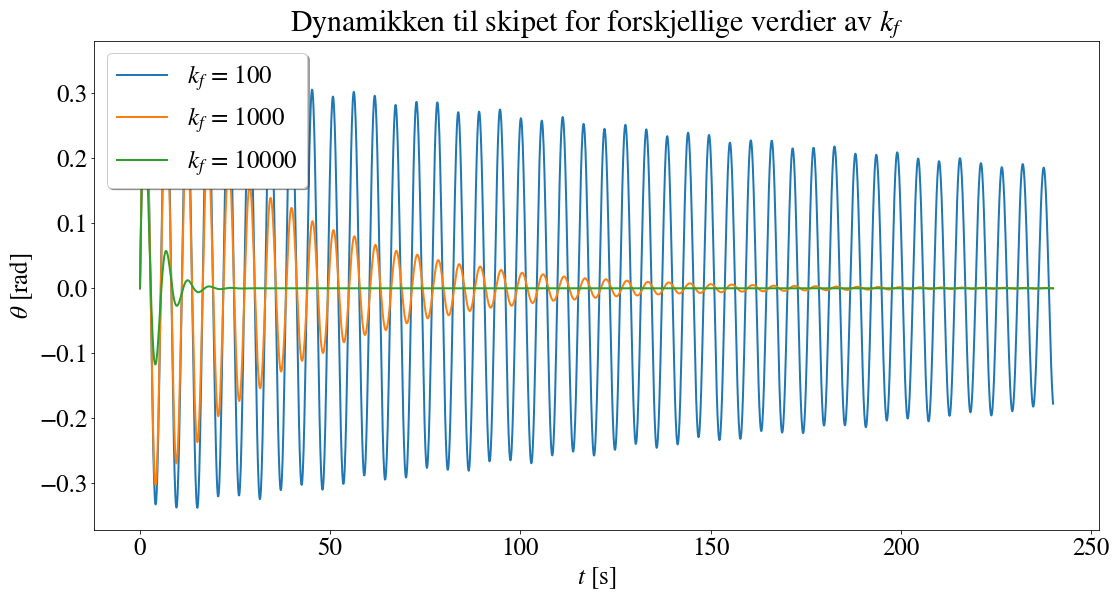

In [44]:
w_start_vals = [0, 0.4, 0, 0, 0, 0, 0, 0]

F_0 = 0
t_end = 240
h_step = 0.1

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

k_f_1 = 100
k_f_2 = 1000
k_f_3 = 10000

k_f_vals = [k_f_1, k_f_2, k_f_3]

m_boat = A_s*sigma
m_L = 0

t_vals = []
w_vals = []
theta_vals = []

for i in range(len(k_f_vals)):
    t_num_temp, w_num_temp = universal_func(w_start_vals, t_end, h_step, F_0, k_f_vals[i], omega_w, m_boat, m_L) 
    
    t_vals.append(t_num_temp)
    w_vals.append(w_num_temp)
    theta_vals.append(w_num_temp[0])
    
labels = []
for k_f_val in k_f_vals:
    labels.append(f"$k_f$ = {k_f_val}")
    
plot_func(t_vals[0], theta_vals, labels, f"Dynamikken til skipet for forskjellige verdier av $k_f$", "$t$ [s]", r"$\theta$ [rad]")

Som man kan se vil båtens vinkelutslag minke litt med tiden for lave verdier av $k_{f}$, men dempes til $0$ nesten umiddelbart for svært store $k_{f}$-verdier. Dersom vi gir det nok tid vil også vinkelutslaget for den lille $k_{f}$-verdien dempes helt til null, men dette vil kreve mer enn $t = 240$ sekunder.

Analytisk kan vi forvente at skipet utfører dempede harmoniske svingninger 

$$
    \theta(t) = \theta_{0}e^{-\delta t}\sin(\omega t)
$$

... skriv mer på dette senere

### 3.9 Bølger og vind

Til slutt vil vi simulere at båten befinner seg i et farvann med bølger og vind. Som nevt tidligere simulerer vi denne krafta som en harmonisk oscillerende kraft rettet horisontalt på tvers av lengderetningen. I tillegg antar vi at det også virker friksjon mellom vannet og skipet.

Som startverdier velger vi $\theta(t_{0} = 0) = 0$ radianer, $\omega(t_{0} = 0) = 2$ grader/s og at massesenteret starter i likevektsposisjonen. Friksjonskoeffesienten settes til å være $k_{f} = 100$ kg/s, og bølgene har en amplitude $F_{0} = 0.625mg$ og treffer båten med en frekvens $\omega_{w} = 0.93\omega_{0}$ med $\omega_{0} = \sqrt{\frac{mgh}{I_{C}}}$

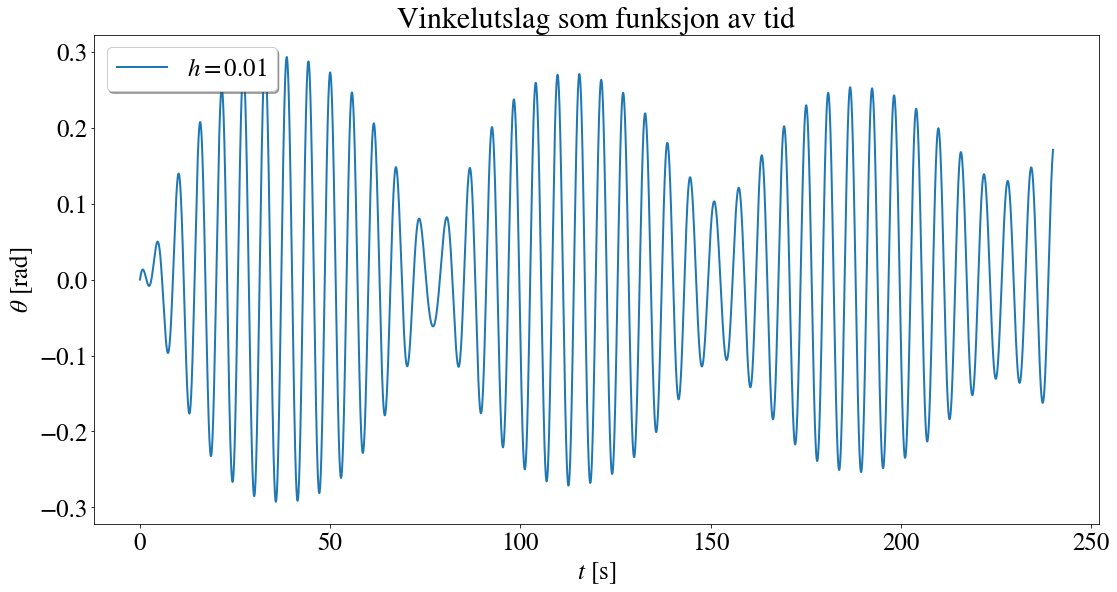

In [16]:
w_start_vals = [0, np.radians(2), 0, 0, 0, 0, 0, 0]

F_0 = F_0 = 0.625*m_boat*g
k_f = 100
t_end = 240
h_step = 0.01

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.93*omega_0

m_boat = A_s*sigma
m_L = 0

t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)

theta_num = w_num[0]
plot_func(t_num, [theta_num], [f"$h = 0.01$"], "Vinkelutslag som funksjon av tid", '$t$ [s]', r'$\theta$ [rad]')

Her kan vi se at vinkelutslaget følger et veldig interessant mønster. Båten gynger relativt raskt frem og tilbake rundt likevekt $\theta = 0$ radianer, men amplituden for hvor stort utslaget vekk fra likevekt er ser ut til moduleres av en modulasjonsbølge med svært lav frekvens. Dette fenomenet kalles sveving, og oppstår som et resultat av at to bølger med nesten lik frekvens går inn og ut av fase med hverandre. 

I vårt tilfelle vil båtens egenfrekvens være $\omega_{0} = \sqrt{\frac{mgh}{I_{C}}} \approx 1.14$ radianer/s, mens frekvensen som bølgene treffer båten med vil være $\omega_{w} = 0.93\omega_{0} = 0.93\sqrt{\frac{mgh}{I_{C}}} \approx 1.06$ radianer/s. Vi legger merke til at disse frekvensene er nesten like store, hvilket gjør at det til tider vil være konstruktiv og til tider destruktiv interferens. Det er nettopp dette som gir opphav til svevingen.

Vi kan også beregne vinkelfrekvensen og perioden til modulasjonsbølgen som modulerer amplituden

$$
  \Delta\omega = \frac{\omega_{0} - \omega_{w}}{2} \approx 0.04  \Rightarrow T = \frac{2\pi}{\Delta\omega} \approx 157 s
$$

og fra plottet vårt ser dette ut til å stemme, hvilket ytterligere verifiserer at vi har med sveving å gjøre.

Dersom vi så antar at bølgene ikke treffer båten med $\omega_{w} = 0.93\omega_{0}$, men med en mye lavere eller høyere frekvens i forhold til båtens egenfrekvens. I et slikt tilfelle vil vi ikke få sveving, men heller en et noe kaotiskt vinkelutslag. La oss teste dette med å sette $\omega_{w} = 0.70\omega_{0}$

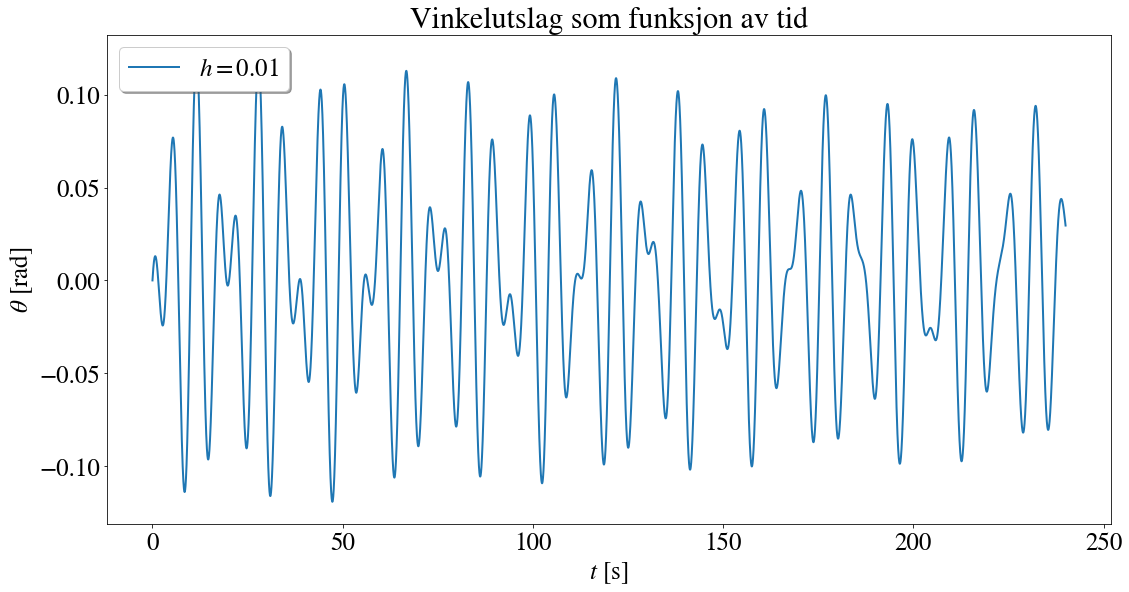

In [18]:
w_start_vals = [0, np.radians(2), 0, 0, 0, 0, 0, 0]

F_0 = F_0 = 0.625*m_boat*g
k_f = 100
t_end = 240
h_step = 0.01

omega_0 = np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))
omega_w = 0.7*omega_0

m_boat = A_s*sigma
m_L = 0

t_num, w_num = universal_func(w_start_vals, t_end, h_step, F_0, k_f, omega_w, m_boat, m_L)

theta_num = w_num[0]
plot_func(t_num, [theta_num], [f"$h = 0.01$"], "Vinkelutslag som funksjon av tid", '$t$ [s]', r'$\theta$ [rad]')

Som man kan se vil vi i dette tilfellet ikke få sveving, men heller et kaotisk vinkelutslag. 

# 4 Partybåt

En interresant tanke som opstår ved undersøkelse av båtens vugging er sammensettingen av bølger. ...

In [ ]:
def fourier_trans(in_fname, arr_name, arr_index, out_fname):
    '''
    This function takes in an array and does a discrete fourier transform on the array. Then 
    it saves the result to a file with given file-name
    Input:
        in_fname: string, the file name where the data is to be loaded from
        arr_name: string, the array within 'in_fname' that is to be transformed
        f_name: string, name of the file that the data is to be saved to
    Output:
        The function does not output anything directly, but saves the following 
        to a file with the given file name 'out_fname':
            X: N/2-array (float), the amplitude normalized fft of x
            freqs: N/2-array(float), the frequencies correspondig to X 
    '''
    dir_name = 'simulation_data/' # Name of the directory where data is stored

    #   Extract the simulation data
    sim_data = np.load(dir_name + in_fname + '.npz')
    w = sim_data[arr_name]
    x = w[arr_index]

    #   Find the (fast) fourier transform
    N = len(x)
    timestep = (x[-1] - x[0])/N

    x_fft = fft(x)[N//2:]   # We are only interrested in the positive part of the frequencies
    X = 2/N * np.abs(x_fft) # Normalize the transform

    freqs = fftfreq(N, timestep)[N//2:]

    #   Save the data to file
    np.savez(
        dir_name + out_fname,
        X = X,
        freqs = freqs
    )

In [ ]:
def fourier_plot(sim_fname, fourier_fname):
    #   Extract the simulation data, and define relevant sizes
    dir_name = 'simulation_data/'
    sim_data = np.load(dir_name + sim_fname + '.npz')
    # print(sim_data.files)
    t_axis, w_vector, boat_info = sim_data['t_num_2'], sim_data['w_num_2'], sim_data['boat_info']

    c_y = w_vector[3]

    beta = calculate_beta(( 2*(boat_info[0]+boat_info[1]) )/( sigma_0*(R**2) ), 5)
    c_y_normalized = c_y - y_C_0(beta)

    #   Plot the initial system
    plot_func(
        t_axis, 
        [c_y_normalized],
        ['Massesenteret, $C$'],
        'Høyde relativt vannoverflaten',
        'Tid, [$s$]',
        'Høyde [$m$]',
        [0]
        )
    

    #   Find the fft of said system
    fourier_data = np.load(dir_name + fourier_fname + '.npz')
    X, freqs = fourier_data['X'], fourier_data['freqs']
    print("1")
    plt.bar(
        freqs,
        X,
    )
    # plt.xlim(0, 500)
    plt.show()
    print("1")





    # ###############################################
    # #   Plotting the fourier transform
    # print(f'Numbe of freqs: {len(freqs)}')
    # print(f'Ved øyemål burde frekvens_1 ligge rundt 0.38Hz, og frekvens_2 ligge rundt 0.012Hz')
    # plt.bar(
    #     freqs,
    #     X,
    #     width = 5/len(X) # Need a width inverse proportional to N, as this is the number of data points 
    # ) 
    # # plt.plot(
    # #     freqs,
    # #     normalized_theta_fft,
    # #     'o'    
    # # )    
    # plt.xlim((0,  0.5))
    # plt.ylabel("Gjennomsnittlig vinkelutslag $\theta$ [$^\circ$]")
    # plt.xlabel("Vinkelfrekvens [Hz(?)]")
    # plt.show()
    



    # print(theta_num)
    # theta_fft = fft(theta_num)


In [ ]:
fourier_trans('2e', 'w_num_2', 3, '2e_centerOfMass_fft')

In [ ]:
fourier_plot('2e', '2e_centerOfMass_fft')

In [ ]:
# a = np.arange(1, 100)
# N = len(a)
# b = a[N//2:]

# print(b)